# Sidekick - Mixture of Gaussian Processes: An Other Approach

### Single-Project Regression
#### Model
We are approaching the problem as time series regression, considering only one project. Our dataset $\mathcal{D} = \left\{ (x_i, y_i) \mid i = 1, ..., n \right\}$ consists of $N$ observations, with $x_i$ the time index of the amount of money $y_i$. Hence, we have $X = [1, ..., N]^T$ an $(Nx1)$ matrix of time indices and $\mathbf{y} = [y_1, ..., y_N]^T$ and vector of observed values. We model the pledged money $f(\mathbf{x})$ at time indices $\mathbf{x}$ as a Gaussian Process:

$$f(\mathbf{x}) \sim GP \left( m(\mathbf{x}), k(\mathbf{x}, \mathbf{x'}) \right). $$

Our goal is to predict the future values of the pledged money $\mathbf{f}_* = \mathbf{f}_{t:N} = f(X_{t:N})$ at future time indices $X_* = X_{t:N} = [t, ..., N]^T$ after observing the values $\mathbf{y} = \mathbf{y}_{1:t} = [y_1, ..., y_t]^T$ at time indices $X = X_{1:t} = [1, ..., t]$. In the GP framework, we can compute this prediction using

$$\mathbf{f}_* \mid X, \mathbf{y}, X_* \sim \mathcal{N}\left(\overline{\mathbf{f}}_*, \text{ cov}(\mathbf{f}_*)  \right) \\
\overline{\mathbf{f}}_* = K(X_*, X) \left[ K(X, X) + \sigma_n^2I \right]^{-1}\mathbf{y} \\
\text{ cov}(\mathbf{f}_*) = K(X_*, X_*) - K(X_*, X)\left[ K(X, X) + \sigma_n^2I \right]^{-1}K(X, X_*).
$$ 

Finally, the kernel's (hyper)parameters $\theta$ are learned by maximizing the *log  marginal likehood*

$$\theta_* = \underset{\theta} {argmax} \log p(\mathbf{y} \mid X, \theta).$$

#### Results
The major problem in this context was that the predictive mean $\mathbf{f}_*$ always falls back to the mean $m(\mathbf{x})$ very quickly. One solution has been to combine two squared-exponential kernels and initializing one of them to a large length-scale in order to capture the global trend. This yields to some reasonable result. However, when applying the same model to another ones (($\theta$ learned over one project and used to predict another) gives very poor performance.


### Multi-Project Regression
#### Model
Hence, our next idea is to consider several projects at the same time and try to learn the hyperparameters $\theta$ over various time series. Our dataset is now $\mathcal{D} = \left\{ (x_i, \mathbf{y}_i) \mid i = 1, ..., n \right\}$ 









For a given project $n$, we are trying to predict the pledged money $\mathbf{f}_*^{(n)} = \mathbf{y}_{t:T}^{(n)}$ at future time indices $\mathbf{x}_*^{(n)} = \mathbf{x}_{t:T}^{(n)} = \mathbf{x}_{t:T} = [t,...,T]^T$ after observing the values $\mathbf{y}^{(n)} = \mathbf{y}_{1:t}^{(n)}$ at time indices $\mathbf{x} = \mathbf{x}_{1:t}$. 
$$\mathbf{f}_{t:T}^{(n)} \mid \mathbf{x}_{1:t}, \mathbf{y}_{1:t}, \mathbf{\theta} \sim GP(\mathbf{\bar{f}_{t:T}^{(n)}}, cov(\mathbf{f}_{t:T}^{(n)})), $$

The hyperparameters $\mathbf{\theta}$ of the GP are learned over $X$ an $(Mx1)$ matrix of input variables and $Y$ an $(MxN)$ matrix of observations corresponding to the $M$ inputs for $N$ projects, by maximizing the marginal log-likelihood:

$$\theta^* = \underset{\theta} {argmax} \log p(Y \mid X, \theta),$$

where 

$$X = \mathbf{x} = [1, 2, 3, ..., M]^T$$
$$Y = \left[y_{11}, y_{12}, ..., y_{1N} \right].$$

Formally, we were computing:

$$p(\mathbf{f}_{t:T}^{(n)} \mid \mathbf{x}_{1:t}, \mathbf{y}_{1:t}, \mathbf{\theta})$$


where  was learned 

We couldn't obtain good results with this approach, as it seems that the hyperparameters $\theta$ are not learned well. Indeed, the predictions always fall back very quickly to the mean of the GP. By initializing one of the kernel with a large lenghtscale, we could obtain the general trend for one project and hence obtain some quite good results, but this approach didn't work when considering several projects for learning or trying to do the predictions for another project.

Therefore, we tried a second approach, namely classification of successful projects. We train one GP on the successful projects, one on the failed projects and try to determine whether a new project will be successful or not. To do so, we would learn $\theta_s$ the hyperparameters of a GP over the *successful* projects only and $\theta_f$ the hyperparameters of a GP over the *failed* projects. Formally, we maximize the marginal log-likelihoods

$$\theta_s^* = \underset{\theta} {argmax} \log p(Y_s \mid X_s, \theta)$$
$$\theta_f^* = \underset{\theta} {argmax} \log p(Y_f \mid X_f, \theta)$$

where $s$ and $f$ denotes the data of the successful and failed projects respectively. We then determine the class of a new, partially observed project as

$$c_{*} = s\text{ if } \log p(\mathbf{y}_{1:t}^{(n)} \mid \mathbf{x}_{1:t}, \theta_s) > \log p(\mathbf{y}_{1:t}^{(n)} \mid \mathbf{x}_{1:t} \mid \theta_f)$$




Instead of using the time as input and trying to predict the output at new time indices, we now consider the value at each time step as input (`y` becomes `x`) and the last time index as the output. 

In [4]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import cPickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick
from misc_utils import progress

DATA_DIR = "../data/sidekick"

## Load data and separate successful from failed projects

In [5]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split()
successful = [project.money for project in projects_train if project.successful]
failed = [project.money for project in projects_train if not project.successful]

Loading projects...
Loading statuses...
Converting to project instances...
Data loaded.


## Train GP-LIN on successful projects

In [1]:
N = 1000
t = 20
T = 999

In [129]:
successful_light = successful[:N]
X_train_s = np.ndarray(shape=(len(successful_light), t), buffer=np.array([money[0:t] for money in successful_light]), dtype=float) 
Y_train_s = np.expand_dims(np.array([money[T] for money in successful_light]), axis=1)
print X_train_s.shape
print Y_train_s.shape

kernel = GPy.kern.Linear(input_dim=t)
m_s = GPy.models.GPRegression(X_train_s, Y_train_s, kernel)
m_s.optimize()
display(m_s)

(1000, 20)
(1000, 1)


GP_regression.,Value,Constraint,Prior,Tied to
linear.variances,758.916288815,+ve,,
Gaussian_noise.variance,6.85125713052,+ve,,


## Train GP-LIN on failed projects

In [128]:
failed_light = failed[:1000]
X_train_f = np.ndarray(shape=(len(failed_light), 20), buffer=np.array([money[0:20] for money in failed_light]), dtype=float) 
Y_train_f = np.expand_dims(np.array([money[-1] for money in failed_light]), axis=1)
print X_train_f.shape
print Y_train_f.shape

kernel = GPy.kern.Linear(input_dim=20) # Try with: ARD=True
m_f = GPy.models.GPRegression(X_train_f, Y_train_f, kernel)
m_f.optimize()
display(m_f)

(1000, 20)
(1000, 1)


GP_regression.,Value,Constraint,Prior,Tied to
linear.variances,7.42798173491,+ve,,
Gaussian_noise.variance,0.0226221692639,+ve,,


## Set up experiment

In [130]:
def predict_total_pledged(project, m_s_test, m_f_test):
    money = np.expand_dims(project.money[:20], axis=0)
    X_observed = np.ndarray(shape=(1, 20), buffer=money, dtype=float)
    yT_f = m_f_test.predict(X_observed)
    yT_s = m_s_test.predict(X_observed)
    
    return yT_f, yT_s

In [144]:
m_s_test = m_s.copy()
m_f_test = m_f.copy()
project_test = projects_test[7]
yT_f, yT_s = predict_total_pledged(project_test, m_s_test, m_f_test)
print "If successful, predicted as %0.4f (%0.4f)" % (yT_s[0][0][0], yT_s[1][0][0])
print "If failed, predicted as %0.4f (%0.4f)" % (yT_f[0][0][0], yT_f[1][0][0])
print "Actual total pledged money: %0.4f" % project_test.money[-1]

If successful, predicted as 2.6164 (7.1267)
If failed, predicted as 1.6915 (0.0676)
Actual total pledged money: 1.0413


In [136]:
for i, p in enumerate(projects_test[:100]):
    if p.successful:
        print i

3
4
6
7
11
12
16
17
21
22
23
24
28
31
33
34
36
44
47
48
49
50
54
58
60
63
64
67
68
69
72
75
77
79
80
82
85
86
89
90
91
93
94
95
99


Goal: $1000
Pledged: $1130


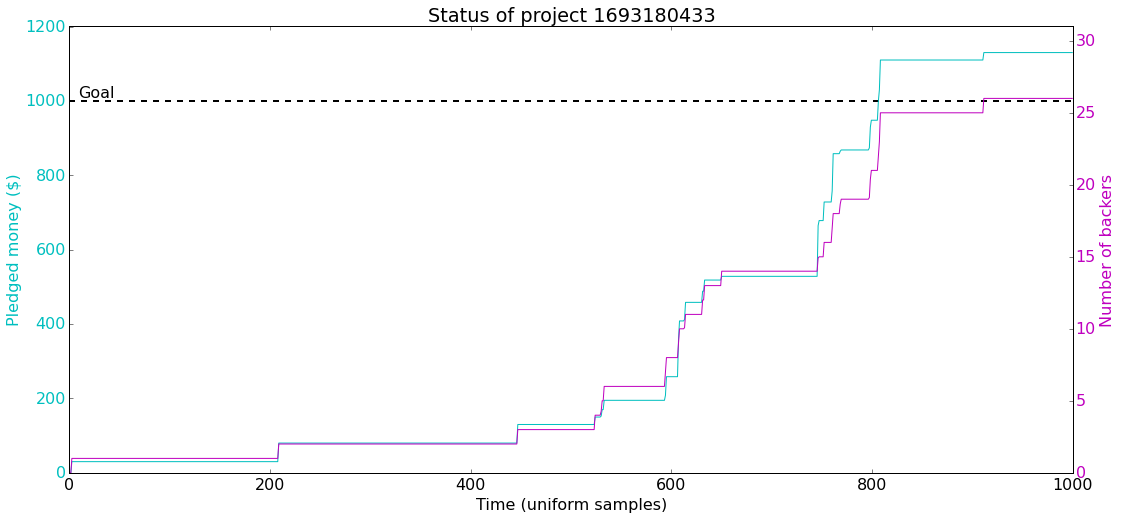

In [141]:
project_test.plot()

## Run experiment

In [8]:
m_s_test = m_s.copy()
m_f_test = m_f.copy()
accuracy = []
predicted = []
actual = []
projects_test_small = projects_test[:100]
np.random.shuffle(projects_test_small)
for project in projects_test_small:
    state = classify_project(project, m_s_test, m_f_test, threshold=1.0)
    predicted.append(state)
    actual.append(int(project.successful))
    accuracy.append(int(state == project.successful))
print "Accuracy %s" % np.mean(accuracy)
print predicted
print actual
print accuracy

Accuracy 0.52
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


## Prototypes
We display here the "prototypical" successful and failed projects and the averaged of each class. We notice that there a clear difference between the two, even with very few observations. Therefore, there is definitely a way to discriminate between the two, but the current approach is not correct.

In [1]:
s = np.array(successful)
mean_s = np.mean(s, axis=0)
std_s = np.std(s, axis=0)
f = np.array(failed)
mean_f = np.mean(f, axis=0)
std_f = np.std(f, axis=0)
plt.errorbar(range(1000), mean_s, std_s / np.sqrt(len(successful)))
plt.errorbar(range(1000), mean_f, std_f / np.sqrt(len(failed)))
plt.legend(['Sucessful', 'Failed'], loc=2)
plt.xlabel('Normalized time')
plt.ylabel('Pledged money')
plt.show()

NameError: name 'np' is not defined